In [61]:
%pip install zss
%pip install lxml
%pip install pandas
%pip install seaborn
%pip install -U sentence-transformers
%pip install gensim
%pip install levenshtein

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.4 MB/s eta 0:00:000:00:01
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.3.1
    Uninstalling sentence-transformers-2.3.1:
      Successfully uninstalled sentence-transformers-2.3.1

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.7/103.7 kB 2.3 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.9 MB/s eta 0:00:000:00:010:00:01:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import xml.etree.ElementTree as ET
from zss import simple_distance, distance, Node
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import gensim.downloader as api
dataset = api.load("text8")
import pickle

In [2]:

A = (
    Node("f")
        .addkid(Node("a")
            .addkid(Node("h"))
            .addkid(Node("c")
                .addkid(Node("l"))))
        .addkid(Node("e"))
    )
B = (
    Node("f")
        .addkid(Node("a")
            .addkid(Node("d"))
            .addkid(Node("c")
                .addkid(Node("b"))))
        .addkid(Node("e"))
    )

In [3]:
print(simple_distance(A, B, return_operations=True))

(2.0, [<Operation Update>, <Operation Update>, <Operation Match>, <Operation Match>, <Operation Match>, <Operation Match>])


In [4]:
tree = ET.parse("data/AT1/ICS2-01.xml")
# with open("data/AT1/ICS2-01.xml", "r") as f:
#     data = f.read()
root = tree.getroot()[0]
print(root.attrib["refinement"])
print(root[0].text)
print(root[1:len(root)])
print(len(root))

disjunctive
Gathering personal data
[<Element 'node' at 0x28249abb0>, <Element 'node' at 0x28249b100>, <Element 'node' at 0x28249b330>]
4


In [5]:
def xmlToZSSTree(file):
    tree = ET.parse(file)
    root = tree.getroot()[0]
    ZSSTree = XMLZSSNode(root)
    return ZSSTree
    # attribute = root.attrib["refinement"]
    # label = root[0].text
    # children = root[1:len(root)]
    # for i in children:
    #     print(i[0].text)
    #     print(i.attrib["refinement"])
    


    
    
def XMLZSSNode(node):
    label = node[0].text
    # print(label)
    refinement = node.attrib["refinement"]
    children = []
    if len(node) > 1:
        xml_children = node[1:len(node)]
        for i in xml_children:
            children.append(XMLZSSNode(i))
    return Node(label, children)
    
    

    

<Axes: >

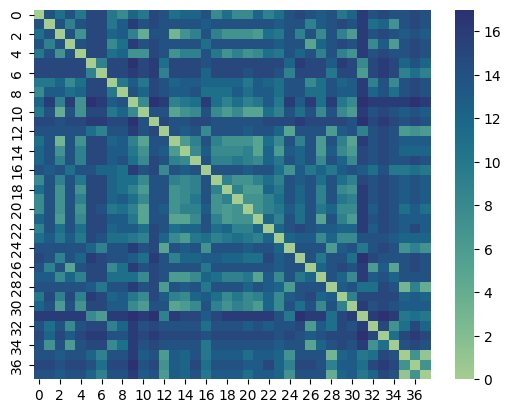

In [6]:


data = []
for i in range(1, 39):
    temp = []
    for j in range(1, 39):
        if i < 10:
            i = "0" + str(i)
        if j < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = simple_distance(T1, T2)#, return_operations=True))
        temp.append(dist)
        # print(i, j, dist)
        i = int(i)
        j = int(j)
    data.append(temp)

simple_df = pd.DataFrame(data)
# print(simple_df)        

sns.heatmap(simple_df, annot=False, cmap="crest")

# print(T1, T2)
# print(simple_distance(T1, T2, return_operations=True))

## Simple Distance

12.339971550497866


<Axes: >

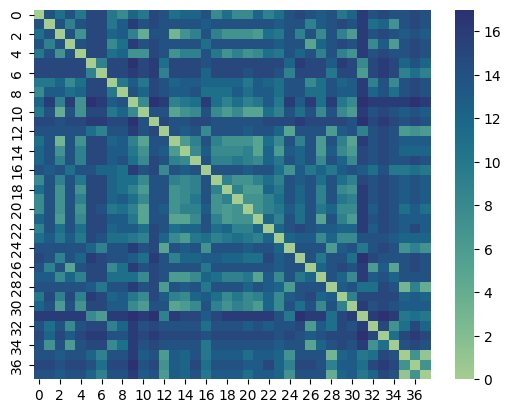

In [33]:
def insert(a):
    return 1
def remove(a):
    return 1
def update(a, b):
    if a == b:
        return 0
    else:
        return 1


data = []
unique = []
for i in range(1, 39):
    temp = []
    for j in range(1, 39):
        if i < 10:
            i = "0" + str(i)
        if j < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = distance(T1, T2, Node.get_children, insert, remove, update)
        temp.append(dist)
        if int(i) < int(j):
            unique.append(dist)
        # print(i, j, dist)
        i = int(i)
        j = int(j)
    data.append(temp)

simple_df = pd.DataFrame(data)
# print(simple_df)        

print(sum(unique)/len(unique))
sns.heatmap(simple_df, annot=False, cmap="crest")

## Structual Only

Nodes can be updated at no cost - so the only cost is with adding and subtracting nodes. Hence this is a comparison of construction.

0.9630156472261735


<Axes: >

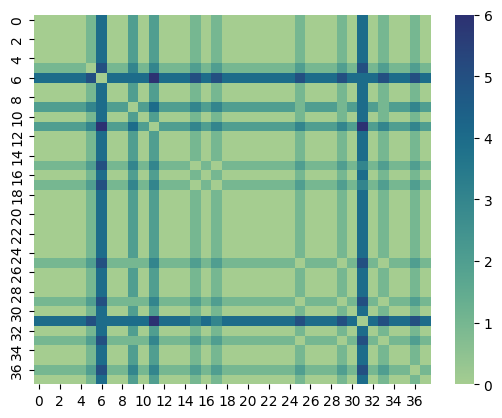

In [34]:
def insert(a):
    return 1
def remove(a):
    return 1
def update(a, b):
    return 0
    if a == b:
        return 0
    else:
        return 1


data = []
unique = []
for i in range(1, 39):
    temp = []
    for j in range(1, 39):
        if i < 10:
            i = "0" + str(i)
        if j < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = distance(T1, T2, Node.get_children, insert, remove, update)
        temp.append(dist)
        if int(i) < int(j):
            unique.append(dist)
        # print(i, j, dist)
        i = int(i)
        j = int(j)
    data.append(temp)

simple_df = pd.DataFrame(data)
# print(simple_df)        

print(sum(unique)/len(unique))
sns.heatmap(simple_df, annot=False, cmap="crest")

0.9630156472261735


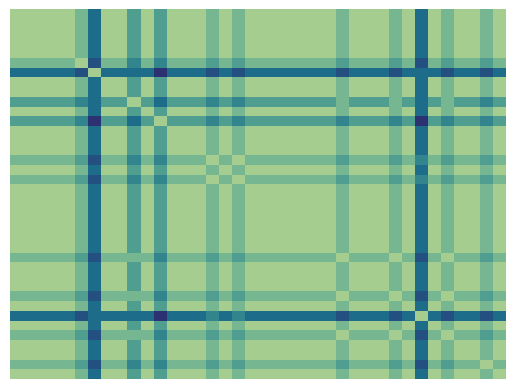

In [61]:
def insert(a):
    return 1
def remove(a):
    return 1
def update(a, b):
    return 0


data = []
unique = []
for i in range(1, 39):
    temp = []
    for j in range(1, 39):
        if i < 10:
            i = "0" + str(i)
        if j < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = distance(T1, T2, Node.get_children, insert, remove, update)
        temp.append(dist)
        if int(i) < int(j):
            unique.append(dist)
        # print(i, j, dist)
        i = int(i)
        j = int(j)
    data.append(temp)

print(sum(unique)/len(unique))
simple_df = pd.DataFrame(data)
# print(simple_df)        


ax = sns.heatmap(simple_df, annot=False, cmap="crest",  yticklabels=False,  xticklabels=False, cbar=False)
ax.tick_params(left=False, bottom=False)
plt.savefig("img/test.png")

In [ ]:
# data = [i for i in dataset]
# def tagged_document(list_of_list_of_words):
#    for i, list_of_words in enumerate(list_of_list_of_words):
#       yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
 
# training_data = list(tagged_document(data))
# model = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30)
 
# model.build_vocab(training_data)
# model.train(training_data, total_examples=model.corpus_count, epochs=model.epochs)

In [43]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

config_sentence_transformers.json: 100%|█████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 408kB/s]
README.md: 100%|████████████████████████████████████████████████████████████████████████████████| 4.12k/4.12k [00:00<00:00, 5.73MB/s]
sentence_bert_config.json: 100%|███████████████████████████████████████████████████████████████████| 53.0/53.0 [00:00<00:00, 265kB/s]
config.json: 100%|██████████████████████████████████████████████████████████████████████████████████| 645/645 [00:00<00:00, 1.81MB/s]
pytorch_model.bin: 100%|██████████████████████████████████████████████████████████████████████████| 471M/471M [00:18<00:00, 25.7MB/s]
tokenizer_config.json: 100%|████████████████████████████████████████████████████████████████████████| 480/480 [00:00<00:00, 3.81MB/s]
tokenizer.json: 100%|███████████████████████████████████████████████████████████████████████████| 9.08M/9.08M [00:00<00:00, 27.1MB/s]
1_Pooling/config.json: 100%|██████████████████████████████████

In [58]:

sentences = [
    'what is the weather tomorrow',
    'will it rain tomorrow',
]
embedding = model.encode(sentences, convert_to_tensor=False)
embedding.shape
cosine_scores = util.cos_sim(embedding, embedding)
print(cosine_scores)
print(float(cosine_scores[0][1]))

d = {}
for i, v1 in enumerate(sentences):
    for j, v2 in enumerate(sentences):
        if i >= j:
            continue
        d[v1 + ' vs. ' + v2] = cosine_scores[i][j].item()

# sort by score
d_sorted = dict(sorted(d.items(), key=lambda x: x[1], reverse=True))
d_sorted


tensor([[1.0000, 0.8253],
        [0.8253, 1.0000]])
0.8252906203269958


{'what is the weather tomorrow vs. will it rain tomorrow': 0.8252906203269958}

In [73]:
from math import sqrt, pow, exp
 
def squared_sum(x):
  """ return 3 rounded square rooted value """
 
  return round(sqrt(sum([a*a for a in x])),3)
 
def euclidean_distance(x,y):
  """ return euclidean distance between two lists """
 
  return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
 
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

def compare(a, b):
    embedding = model.encode([a,b], convert_to_tensor=False)
    cosine_scores = util.cos_sim(embedding, embedding)
    return round(float(float(cosine_scores[0][1])),4)
    # vectors = [model.infer_vector([word for word in sent]).reshape(1,-1) for sent in [a, b]]
    # # print(vectors[0])
    # return cos_similarity(vectors[0][0],vectors[1][0])
    

In [ ]:
# vectors = [model.infer_vector([word for word in sent]).reshape(1,-1) for sent in sentences]

# similarity = []
# for i in range(len(sentences)):
#    row = []
#    for j in range(len(sentences)):
#         # print(vectors[i])
#         row.append(cos_similarity(vectors[i][0],vectors[j][0]))
#    similarity.append(row)
# print(sentences)
# print(similarity)
# create_heatmap(similarity)

In [59]:
import time

lims = []
lims.extend([round(.9 + .01*i, 4) for i in range(0, 7)])
lims.extend([round(.96 + .001*i, 4) for i in range(0, 10)])
lims.extend([round(.97 + .001*i, 4) for i in range(0, 10)])
lims.extend([round(.98 + .001*i, 4) for i in range(0, 10)])
lims.extend([round(.99 + .001*i, 4) for i in range(0, 10)])
lims.append(1)

def insert(a):
    return 1
def remove(a):
    return 1
lim = .9
def update(a, b):
    if compare(a.label, b.label) > lim:
        return 0
    else:
        return 1



all_data3 = []
for k in lims:
    start = time.time()
    # lim = .90 + .01*k
    lim = k
    print(lim)
    data = []
    unique = []
    for i in range(1, 39):
        temp = []
        for j in range(1, 39):
            if i < 10:
                i = "0" + str(i)
            if j < 10:
                j = "0" + str(j)
            T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
            T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
            dist = distance(T1, T2, Node.get_children, insert, remove, update)
            temp.append(dist)
            if int(i) < int(j):
                unique.append(dist)
            # print(i, j, dist)
            i = int(i)
            j = int(j)
        data.append(temp)  
    end = time.time()
    print(end - start, sum(unique)/len(unique))
    simple_df = pd.DataFrame(data)
    all_data3.append((lim, simple_df))
    # ax = sns.heatmap(simple_df, annot=False, cmap="crest",  yticklabels=False,  xticklabels=False, cbar=False)
    # ax.tick_params(left=False, bottom=False)
    # plt.savefig("img/sim_dist_heatmaps/lim-"+str(lim)+".png")
with open('48lims_v2', 'wb') as fp:
    pickle.dump(all_data3, fp) 


# sns.heatmap(simple_df, annot=False, cmap="crest")

0.9


KeyboardInterrupt: 

In [70]:
# with open('lim991-999', 'wb') as fp:
#     pickle.dump(all_data, fp)

In [82]:
lims = []
for i in range(0,10):
    # lims.append(round(.1*i,4))
    for j in range(0,10):
        lims.append(round(.1*i+.01*j, 4))
    
# lims.extend([round(.9 + .01*i, 4) for i in range(0, 7)])
# lims.extend([round(.96 + .001*i, 4) for i in range(0, 10)])
# lims.extend([round(.97 + .001*i, 4) for i in range(0, 10)])
# lims.extend([round(.98 + .001*i, 4) for i in range(0, 10)])
# lims.extend([round(.99 + .001*i, 4) for i in range(0, 10)])
lims.append(1)
print(lims)
print(len(lims))

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
101


In [7]:
with open('lim991-999', 'rb') as fp:
    print(pickle.load(fp))

NameError: name 'pickle' is not defined

/var/folders/fx/2dlwmb311n9bt5nz3dllsh6m0000gn/T/ipykernel_30190/2313826226.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tdf["limit"][i] = str(tdf["limit"][i]) + "00"
/var/folders/fx/2dlwmb311n9bt5nz3dllsh6m0000gn/T/ipykernel_30190/2

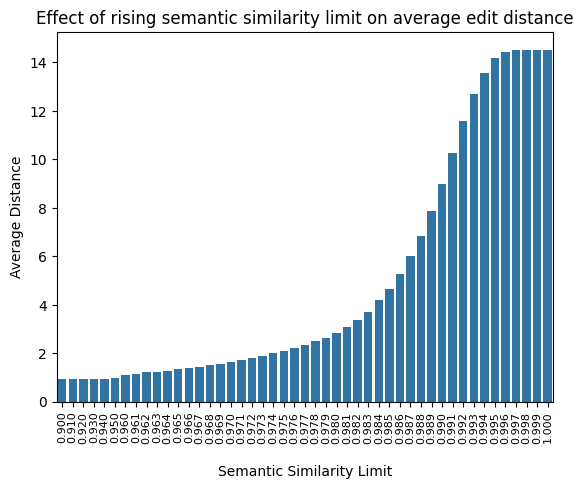

In [9]:
# with open('lim991-999', 'rb') as fp:
#     thedata = pickle.load(fp)
# with open('lim90-1', 'rb') as fp:
#     thedata2 = pickle.load(fp)
# thedata.extend(thedata2)
# print(len(thedata))

with open('48lims', 'rb') as fp:
    thedata = pickle.load(fp)


def extractUnique(tdf):
    # print(df)
    toRet = []
    for i in range(len(tdf)):
        for j in range(i, len(tdf[i])):
            # print(i, j)
            toRet.append(tdf[i][j])
    return toRet


tracker = []
skip1 = True
for k in range(len(thedata)):
    unique = extractUnique(pd.DataFrame(thedata[k][1]))
    # tracker.append((thedata[k][0], min(unique)))
    if thedata[k][0] == .96 and skip1:
        skip1 = False
        continue
    tracker.append((thedata[k][0], sum(unique)/len(unique)))
    # tracker.append((thedata[k][0], max(unique)))
# # print(tracker)
# ordered = []
# ordered.extend(tracker[9:18])
# ordered.extend(tracker[0:9])
# ordered.append(tracker[18])
# # print(ordered)

# print(tracker)
tdf = pd.DataFrame(tracker)
tdf.columns = ["limit", "average distance"]
for i in range(0, len(tdf["limit"])):
    if len(str(tdf["limit"][i])) == 3:
        tdf["limit"][i] = str(tdf["limit"][i]) + "00"
    if len(str(tdf["limit"][i])) == 4:
        tdf["limit"][i] = str(tdf["limit"][i]) + "0"
        # print(i)
        
# print(tdf)

sns.barplot(tdf, x="limit", y ="average distance", err_kws={"linewidth":.5})
plt.xlabel("\nSemantic Similarity Limit")
plt.ylabel("Average Distance")
plt.xticks(fontsize=8, rotation=90)
plt.title("Effect of rising semantic similarity limit on average edit distance")    

plt.savefig("img/similaritylimits.pdf", bbox_inches='tight')

In [77]:
from Levenshtein import distance

distance("lewenstein", "levenshtein")

def lvs(a, b):
    print(compare(a, b), distance(a,b))

lvs("obtain personal data", "obtain personnel")
lvs("obtain personal data", "gather private info")
lvs("break open safe", "break open door")
lvs("break open safe", "crack safe open")
lvs("crack safe", "crack door")
lvs("door open", "open door")
# print(compare("obtain personal data", "obtain personnel"))

0.4507 7
0.5521 15
0.7855 4
0.814 11
0.6692 4
0.992 8
